This version of Chandler Zuo's implementation of the paper: **A Dual-Stage Attention-Based Recurrent Neural Network for Time Series Prediction** (see http://chandlerzuo.github.io/blog/2017/11/darnn)
generalizes the input data to Chandler Zuo's da_rnn model.  

To use:

**Instantiate the class da_rnn with the following parameters:**
 * a pandas DataFrame whose columns are numeric features of time series data (NOT the path to a csv file).  
 * a logger (use the method setup_log())
 * an argument specifying whether you can run the model in parallel
 * learning rate
 
 ``` m = da_rnn(df_partial, logger = logger, parallel = False, learning_rate = .001) ```

**The data in the DataFrame can be like:**
   1. the returns data for the components of an index like NDX (as in Chandler Zuo's version) as in the csv file ./data/nasdaq100_padding.csv, or 
   2. intra-day bar data with columns like **year, month, day, hour, minute open, high, low, close**, as in the csv file ./data/uso_full.csv
   
  

The actual model training takes place in the cell below heading **4.01**, with the code:

<code>
    logger = setup_log()
    m = da_rnn(df_partial, logger = logger, parallel = False, learning_rate = .001)
    m.execute_training(n_epochs=100)
</code>

If you use pdb, see the cheatsheet  https://appletree.or.kr/quick_reference_cards/Python/Python%20Debugger%20Cheatsheet.pdf 


### 1.01 Define dependencies

In [1]:
import pdb
import  numpy as np
import torch 
from torch import nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F
import logging
import subprocess
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import pickle
# from sklearn.manifold import TSNE

# local_data_dir = './temp_folder'
%matplotlib inline
np.set_printoptions(suppress=True)
pd.set_option('display.max_rows',1000)
pd.set_option('display.max_columns',1000)


#### 1.02 Define a method that creates a python logger 

In [2]:
def setup_log(tag = 'VOC_TOPICS'):
    # create logger
    logger = logging.getLogger(tag)
    # logger.handlers = []
    logger.propagate = False
    logger.setLevel(logging.DEBUG)
    # create console handler and set level to debug
    ch = logging.StreamHandler()
    ch.setLevel(logging.DEBUG)
    # create formatter
    formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
    # add formatter to ch
    ch.setFormatter(formatter)
    # add ch to logger
    # logger.handlers = []
    logger.addHandler(ch)
    return logger



### 2.0 Define the main components of the RNN model
#### 2.01 Define the encoder:

In [3]:
class encoder(nn.Module):
    def __init__(self, input_size, hidden_size, T):
        # input size: number of underlying factors (81)
        # T: number of time steps (10)
        # hidden_size: dimension of the hidden state
        super(encoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.T = T

        self.lstm_layer = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = 1)
        self.attn_linear = nn.Linear(in_features = 2 * hidden_size + T - 1, out_features = 1)

    def forward(self, input_data):
        # T is the number of time steps that we iterate through to implement attention
        # input_size is the number of features in the input data
        # input_data.shape:     batch_size, T - 1, input_size
        # input_weighted.shape: batch_size, T - 1, input_size
        # input_encoded.shape:  batch_size, T - 1, hidden_size
        input_weighted = Variable(input_data.data.new(input_data.size(0), self.T - 1, self.input_size).zero_())
        input_encoded = Variable(input_data.data.new(input_data.size(0), self.T - 1, self.hidden_size).zero_())
#         pdb.set_trace()
        
        # hidden, cell: initial states with dimention hidden_size
        # hidden.shape = 1, batch_size, hidden_size
        hidden = self.init_hidden(input_data)
        # cell.shape = 1, batch_size, hidden_size
        cell = self.init_hidden(input_data) 
        # hidden.requires_grad = False
        # cell.requires_grad = False
        
        # In each loop of t, update the tensors hidden and cell, and 
        #   update the tensors input_weighted (the "pre-lstm" inputs to the lstm layer) and 
        #   input_encoded (the hidden layer that comes out of each lstm call)
        # input_encoded contains the h values that get fed into the decoder
        # input_weighted contains the x values that get fed into into the encoder's lstm on each time-step.
        for t in range(self.T - 1):
            # Eqn. 8: concatenate the hidden states with each predictor
            # There are 3 tensors: hidden, cell and input_data.  
            c1 = hidden.repeat(self.input_size, 1, 1).permute(1, 0, 2)   # torch tensor dimensions = [batch_size, input_size, hidden_size]
            c2 = cell.repeat(self.input_size, 1, 1).permute(1, 0, 2)     # torch tensor dimensions = [batch_size, input_size, hidden_size]
            c3 = input_data.permute(0, 2, 1)                             # torch tensor dimensions = [batch_size, input_size, T-1]
            x = torch.cat((c1,c2,c3),dim=2) # torch tensor dimensions = [batch_size, input_size,(2*hidden_size + T - 1)]
            # Eqn. 9: Get attention weights
            attn_input = x.view(-1, self.hidden_size * 2 + self.T - 1)   # torch tensor dimensions = [batch_size * input_size, 2*hidden_size + T - 1]
            x = self.attn_linear(attn_input) # torch tensor dimensions = [batch_size * input_size, 1]
            softmax_input = x.view(-1, self.input_size)  # reshape x back into torch tensor dimensions = [batch_size,input_size]
            attn_weights = F.softmax(softmax_input) # torch tensor dimensions = [batch_size * input_size] andattn weights with values sum up to 1.
            # Eqn. 10: LSTM
            weighted_input = torch.mul(attn_weights, input_data[:, t, :]) # batch_size, input_size
            # Fix the warning about non-contiguous memory
            # see https://discuss.pytorch.org/t/dataparallel-issue-with-flatten-parameter/8282
            self.lstm_layer.flatten_parameters()
            _, lstm_states = self.lstm_layer(weighted_input.unsqueeze(0), (hidden, cell))
            hidden = lstm_states[0]
            cell = lstm_states[1]
            # Save output
            input_weighted[:, t, :] = weighted_input
            input_encoded[:, t, :] = hidden
        return input_weighted, input_encoded

    def init_hidden(self, x):
        # No matter whether CUDA is used, the returned variable will have the same type as x.
        return Variable(x.data.new(1, x.size(0), self.hidden_size).zero_()) # dimension 0 is the batch dimension


#### 2.02 Define the decoder:

In [4]:
class decoder(nn.Module):
    def __init__(self, encoder_hidden_size, decoder_hidden_size, T):
        super(decoder, self).__init__()

        self.T = T
        self.encoder_hidden_size = encoder_hidden_size
        self.decoder_hidden_size = decoder_hidden_size


        self.attn_layer = nn.Sequential(nn.Linear(2 * decoder_hidden_size + encoder_hidden_size, encoder_hidden_size),
                                         nn.Tanh(), nn.Linear(encoder_hidden_size, 1))
        self.lstm_layer = nn.LSTM(input_size = 1, hidden_size = decoder_hidden_size)
        self.fc = nn.Linear(encoder_hidden_size + 1, 1)
        self.fc_final = nn.Linear(decoder_hidden_size + encoder_hidden_size, 1)

        self.fc.weight.data.normal_()

    def forward(self, input_encoded, y_history):
        # input_encoded: batch_size,T - 1,encoder_hidden_size
        # y_history: batch_size, (T-1)
        # Initialize hidden and cell, 1 * batch_size * decoder_hidden_size
        hidden = self.init_hidden(input_encoded)
        cell = self.init_hidden(input_encoded)
        # hidden.requires_grad = False
        # cell.requires_grad = False
        for t in range(self.T - 1):
            # Eqn. 12-13: compute attention weights
            ## batch_size * T * (2*decoder_hidden_size + encoder_hidden_size)
            x = torch.cat((hidden.repeat(self.T - 1, 1, 1).permute(1, 0, 2),
                           cell.repeat(self.T - 1, 1, 1).permute(1, 0, 2), input_encoded), dim = 2)
            x = F.softmax(self.attn_layer(x.view(-1, 2 * self.decoder_hidden_size + self.encoder_hidden_size
                                                )).view(-1, self.T - 1)) # batch_size * T - 1, row sum up to 1
            # Eqn. 14: compute context vector
            context = torch.bmm(x.unsqueeze(1), input_encoded)[:, 0, :] # batch_size * encoder_hidden_size
            if t < self.T - 1:
                # Eqn. 15
                y_tilde = self.fc(torch.cat((context, y_history[:, t].unsqueeze(1)), dim = 1)) # batch_size * 1
                # Eqn. 16: LSTM
                self.lstm_layer.flatten_parameters()
                _, lstm_output = self.lstm_layer(y_tilde.unsqueeze(0), (hidden, cell))
                hidden = lstm_output[0] # 1 * batch_size * decoder_hidden_size
                cell = lstm_output[1] # 1 * batch_size * decoder_hidden_size
        # Eqn. 22: final output
        y_pred = self.fc_final(torch.cat((hidden[0], context), dim = 1))
        return y_pred

    def init_hidden(self, x):
        return Variable(x.data.new(1, x.size(0), self.decoder_hidden_size).zero_())


#### 2.03 Define the RNN class, that uses the encoder and decoder

In [5]:
class da_rnn:
    # the __getstate__ and __setstate__ methods allow you to avoid trying to pickle the logger.
    def __getstate__(self):
        d = dict(self.__dict__)
        del d['logger']
        return d
    
    def __setstate__(self, d):
        self.__dict__.update(d) 
        self.logger = setup_log()
    
    
    def __init__(self, df_dat, logger, encoder_hidden_size = 64, decoder_hidden_size = 64, T = 10,
                 learning_rate = 0.01, batch_size = 128, parallel = True, debug = False,ticker='NDX'):
        self.df_dat = df_dat
        self.T = T
        self.logger = logger
        self.logger.info("Shape of data: %s.\nMissing in data: %s." %(str(df_dat.shape), str(df_dat.isnull().sum().sum())))
        self.x_columns = [x for x in df_dat.columns.tolist() if x != ticker]
        self.X = df_dat.loc[:, self.x_columns].as_matrix()
        self.y = np.array(df_dat[ticker])
        self.batch_size = batch_size

        self.encoder = encoder(input_size = self.X.shape[1], hidden_size = encoder_hidden_size, T = T)
        self.decoder = decoder(encoder_hidden_size = encoder_hidden_size,
                               decoder_hidden_size = decoder_hidden_size,
                               T = T)
        
        if parallel:
            self.encoder = nn.DataParallel(self.encoder)
            self.decoder = nn.DataParallel(self.decoder)

        self.encoder_optimizer = optim.Adam(params = filter(lambda p: p.requires_grad, self.encoder.parameters()),
                                           lr = learning_rate)
        self.decoder_optimizer = optim.Adam(params = filter(lambda p: p.requires_grad, self.decoder.parameters()),
                                           lr = learning_rate)
        self.ticker = ticker
        self.train_size = int(self.X.shape[0] * 0.7)
        self.y_train_mean = np.mean(self.y[:self.train_size])
        self.y = self.y - self.y_train_mean # Question: why Adam requires data to be normalized?
        self.logger.info("Training size: %d."  %(self.train_size))

    def train(self, n_epochs = 10):
        iter_per_epoch = int(np.ceil(self.train_size * 1. / self.batch_size))
        self.logger.info("Iterations per epoch: %d." %(iter_per_epoch))
        self.iter_losses = np.zeros(n_epochs * iter_per_epoch)
        self.epoch_losses = np.zeros(n_epochs)

        self.loss_func = nn.MSELoss()

        n_iter = 0

        learning_rate = 1.

        for i in range(n_epochs):
            perm_idx = np.random.permutation(self.train_size - self.T)
            j = 0
            while j < self.train_size:
                batch_idx = perm_idx[j:(j + self.batch_size)]
                X = np.zeros((len(batch_idx), self.T - 1, self.X.shape[1]))
                y_history = np.zeros((len(batch_idx), self.T - 1))
                y_target = self.y[batch_idx + self.T]

                for k in range(len(batch_idx)):
                    X[k, :, :] = self.X[batch_idx[k] : (batch_idx[k] + self.T - 1), :]
                    y_history[k, :] = self.y[batch_idx[k] : (batch_idx[k] + self.T - 1)]

                loss = self.train_iteration(X, y_history, y_target)
                self.iter_losses[int(i * iter_per_epoch + j / self.batch_size)] = loss
                j += self.batch_size
                n_iter += 1

                if n_iter % 10000 == 0 and n_iter > 0:
                    for param_group in self.encoder_optimizer.param_groups:
                        param_group['lr'] = param_group['lr'] * 0.9
                    for param_group in self.decoder_optimizer.param_groups:
                        param_group['lr'] = param_group['lr'] * 0.9
                '''
                if learning_rate > self.learning_rate:
                    for param_group in self.encoder_optimizer.param_groups:
                        param_group['lr'] = param_group['lr'] * .9
                    for param_group in self.decoder_optimizer.param_groups:
                        param_group['lr'] = param_group['lr'] * .9
                    learning_rate *= .9
                '''


            self.epoch_losses[i] = np.mean(self.iter_losses[range(i * iter_per_epoch, (i + 1) * iter_per_epoch)])
            if i % 10 == 0:
                self.logger.info("Epoch %d, loss: %3.3f." %(i, self.epoch_losses[i]))

            if i % 10 == 0:
                y_train_pred = self.predict(on_train = True)
                y_test_pred = self.predict(on_train = False)
                y_pred = np.concatenate((y_train_pred, y_test_pred))
                plt.figure()
                plt.plot(range(1, 1 + len(self.y)), self.y, label = "True")
                plt.plot(range(self.T , len(y_train_pred) + self.T), y_train_pred, label = 'Predicted - Train')
                plt.plot(range(self.T + len(y_train_pred) , len(self.y) + 1), y_test_pred, label = 'Predicted - Test')
                plt.legend(loc = 'upper left')
                plt.show()

    def train_iteration(self, X, y_history, y_target):
        self.encoder_optimizer.zero_grad()
        self.decoder_optimizer.zero_grad()

        input_weighted, input_encoded = self.encoder(Variable(torch.from_numpy(X).type(torch.FloatTensor)))
        y_pred = self.decoder(input_encoded, Variable(torch.from_numpy(y_history).type(torch.FloatTensor)))
        y_true = Variable(torch.from_numpy(y_target).type(torch.FloatTensor)).reshape(y_target.shape[0],1)
        
        loss = self.loss_func(y_pred, y_true)
        loss.backward()

        self.encoder_optimizer.step()
        self.decoder_optimizer.step()

        return loss.data[0]

    def predict(self, on_train = False):
        if on_train:
            y_pred = np.zeros(self.train_size - self.T + 1)
        else:
            y_pred = np.zeros(self.X.shape[0] - self.train_size)

        i = 0
        while i < len(y_pred):
            batch_idx = np.array(range(len(y_pred)))[i : (i + self.batch_size)]
            X = np.zeros((len(batch_idx), self.T - 1, self.X.shape[1]))
            y_history = np.zeros((len(batch_idx), self.T - 1))
            for j in range(len(batch_idx)):
                if on_train:
                    X[j, :, :] = self.X[range(batch_idx[j], batch_idx[j] + self.T - 1), :]
                    y_history[j, :] = self.y[range(batch_idx[j],  batch_idx[j]+ self.T - 1)]
                else:
                    X[j, :, :] = self.X[range(batch_idx[j] + self.train_size - self.T, batch_idx[j] + self.train_size - 1), :]
                    y_history[j, :] = self.y[range(batch_idx[j] + self.train_size - self.T,  batch_idx[j]+ self.train_size - 1)]
            
            y_history = Variable(torch.from_numpy(y_history).type(torch.FloatTensor))
            _, input_encoded = self.encoder(Variable(torch.from_numpy(X).type(torch.FloatTensor)))
            y_pred[i:(i + self.batch_size)] = self.decoder(input_encoded, y_history).cpu().data.numpy()[:, 0]
            
            i += self.batch_size
        return y_pred

    def execute_training(self,n_epochs=500):
        use_cuda = torch.cuda.is_available()
        self.logger.info("Is CUDA available? %s." %(str(use_cuda)))


        self.train(n_epochs = n_epochs)

        y_pred = self.predict()

        plt.figure()
        plt.semilogy(range(len(self.iter_losses)), self.iter_losses)
        plt.show()

        plt.figure()
        plt.semilogy(range(len(self.epoch_losses)), self.epoch_losses)
        plt.show()

        plt.figure()
        plt.plot(y_pred, label = 'Predicted')
        plt.plot(self.y[self.train_size:], label = "True")
        plt.legend(loc = 'upper left')
        plt.show()


### 3.0 Launch the training of the RNN

#### 3.01 Read the main csv file, and add appropriate date columns
 2 possible csv files are provided:
   1. Chandler Zuo's orginal nasdaq100 csv file;
   2. A file of one minute bar data for the commodity ETF USO
 
Comment out one, and use the other.

In [6]:
DATA_DIR = './data'
FILE_NAME_NO_EXT = 'nasdaq100_padding'
# FILE_NAME_NO_EXT = 'uso_full'
data_file = f'{DATA_DIR}/{FILE_NAME_NO_EXT}.csv'

# get data
df = pd.read_csv(data_file)


In [7]:
df.columns.values,df.as_matrix().shape

(array(['AAL', 'AAPL', 'ADBE', 'ADI', 'ADP', 'ADSK', 'AKAM', 'ALXN',
        'AMAT', 'AMGN', 'AMZN', 'ATVI', 'AVGO', 'BBBY', 'BIDU', 'BIIB',
        'CA', 'CELG', 'CERN', 'CMCSA', 'COST', 'CSCO', 'CSX', 'CTRP',
        'CTSH', 'DISCA', 'DISH', 'DLTR', 'EA', 'EBAY', 'ESRX', 'EXPE',
        'FAST', 'FB', 'FOX', 'FOXA', 'GILD', 'GOOGL', 'INTC', 'JD', 'KHC',
        'LBTYA', 'LBTYK', 'LRCX', 'MAR', 'MAT', 'MCHP', 'MDLZ', 'MSFT',
        'MU', 'MXIM', 'MYL', 'NCLH', 'NFLX', 'NTAP', 'NVDA', 'NXPI',
        'PAYX', 'PCAR', 'PYPL', 'QCOM', 'QVCA', 'ROST', 'SBUX', 'SIRI',
        'STX', 'SWKS', 'SYMC', 'TMUS', 'TRIP', 'TSCO', 'TSLA', 'TXN',
        'VIAB', 'VOD', 'VRTX', 'WBA', 'WDC', 'WFM', 'XLNX', 'YHOO', 'NDX'],
       dtype=object), (40560, 82))

In [8]:
# don't skew the days
if 'close' in df.columns.values:
    print('moving the close column to the NDX')
    df['NDX'] = df['close']

#### 3.02 create a subset of the main csv by changing NUM_ROWS_TO_USE

In [9]:
NUM_ROWS_TO_USE=5000
NUM_VALIDATION_ROWS = NUM_ROWS_TO_USE // 10
BEG_ROW = -1 * NUM_ROWS_TO_USE
END_ROW = None #BEG_ROW + NUM_ROWS_TO_USE
# num_df_rows = len(df)
df_partial = df.iloc[BEG_ROW:END_ROW]

In [10]:
print(df_partial.columns.values,len(df_partial))

['AAL' 'AAPL' 'ADBE' 'ADI' 'ADP' 'ADSK' 'AKAM' 'ALXN' 'AMAT' 'AMGN' 'AMZN'
 'ATVI' 'AVGO' 'BBBY' 'BIDU' 'BIIB' 'CA' 'CELG' 'CERN' 'CMCSA' 'COST'
 'CSCO' 'CSX' 'CTRP' 'CTSH' 'DISCA' 'DISH' 'DLTR' 'EA' 'EBAY' 'ESRX'
 'EXPE' 'FAST' 'FB' 'FOX' 'FOXA' 'GILD' 'GOOGL' 'INTC' 'JD' 'KHC' 'LBTYA'
 'LBTYK' 'LRCX' 'MAR' 'MAT' 'MCHP' 'MDLZ' 'MSFT' 'MU' 'MXIM' 'MYL' 'NCLH'
 'NFLX' 'NTAP' 'NVDA' 'NXPI' 'PAYX' 'PCAR' 'PYPL' 'QCOM' 'QVCA' 'ROST'
 'SBUX' 'SIRI' 'STX' 'SWKS' 'SYMC' 'TMUS' 'TRIP' 'TSCO' 'TSLA' 'TXN'
 'VIAB' 'VOD' 'VRTX' 'WBA' 'WDC' 'WFM' 'XLNX' 'YHOO' 'NDX'] 5000


## 4.0  Execute training
#### 4.01 run the model

2019-01-02 22:28:56,591 - VOC_TOPICS - INFO - Shape of data: (5000, 82).
Missing in data: 0.
2019-01-02 22:28:56,601 - VOC_TOPICS - INFO - Training size: 3500.
2019-01-02 22:28:56,603 - VOC_TOPICS - INFO - Is CUDA available? False.
2019-01-02 22:28:56,604 - VOC_TOPICS - INFO - Iterations per epoch: 28.
/Users/bperlman1/Virtualenvs3/pyliverisk/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/bperlman1/Virtualenvs3/pyliverisk/lib/python3.6/site-packages/ipykernel_launcher.py:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/bperlman1/Virtualenvs3/pyliverisk/lib/python3.6/site-packages/ipykernel_launcher.py:116: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
2019-01-02 22:29:01,8

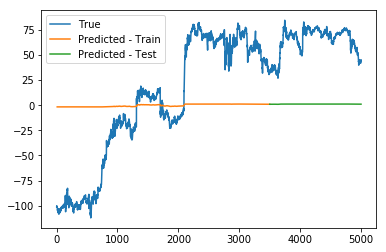

2019-01-02 22:29:54,161 - VOC_TOPICS - INFO - Epoch 10, loss: 881.596.


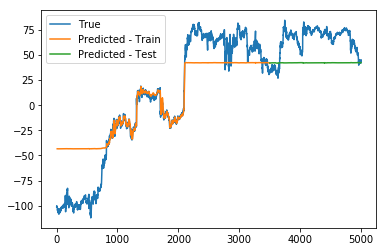

2019-01-02 22:30:47,041 - VOC_TOPICS - INFO - Epoch 20, loss: 239.649.


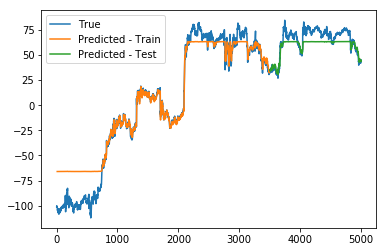

2019-01-02 22:31:36,545 - VOC_TOPICS - INFO - Epoch 30, loss: 86.791.


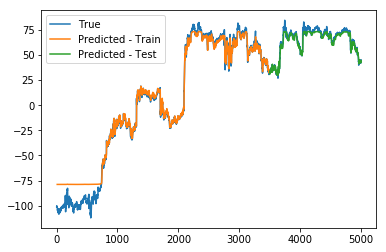

2019-01-02 22:32:26,501 - VOC_TOPICS - INFO - Epoch 40, loss: 34.522.


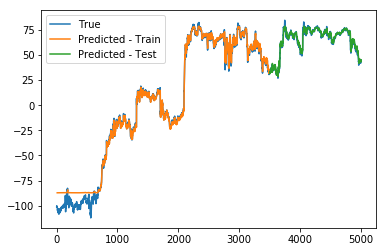

2019-01-02 22:33:14,516 - VOC_TOPICS - INFO - Epoch 50, loss: 16.593.


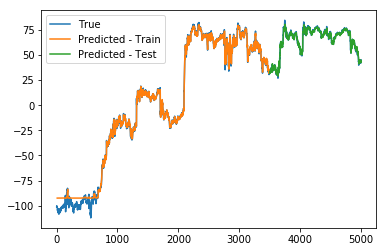

2019-01-02 22:34:03,002 - VOC_TOPICS - INFO - Epoch 60, loss: 11.041.


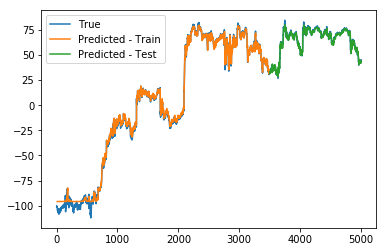

2019-01-02 22:34:50,113 - VOC_TOPICS - INFO - Epoch 70, loss: 8.224.


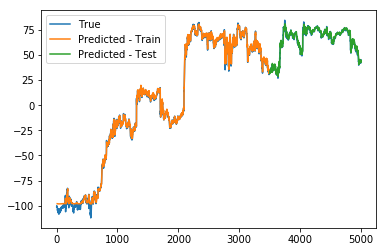

2019-01-02 22:35:37,844 - VOC_TOPICS - INFO - Epoch 80, loss: 6.949.


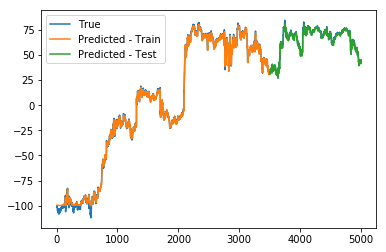

2019-01-02 22:36:26,354 - VOC_TOPICS - INFO - Epoch 90, loss: 6.497.


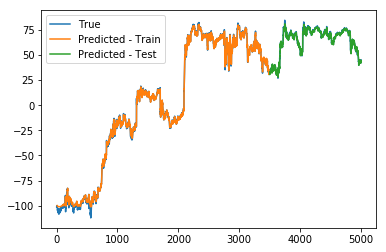

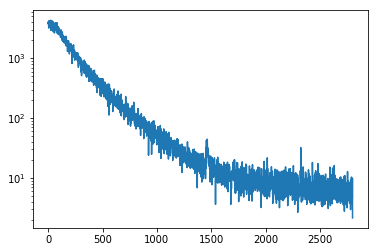

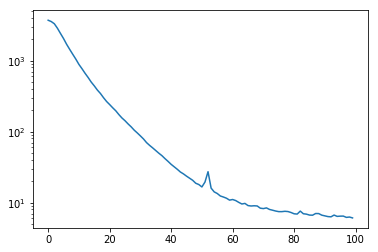

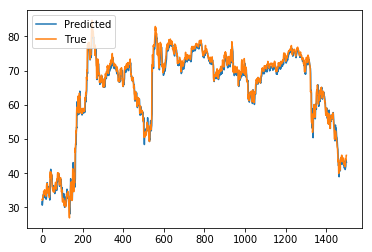

In [11]:
logger = setup_log()
m = da_rnn(df_partial, logger = logger, parallel = False,
              learning_rate = .001)
m.execute_training(n_epochs=100)

#### 4.02 create method to execute predictions for the model that we just trained, but with any DataFrame that has the same columns

In [17]:
def pred_df(df_test,model):
    # get the x values for the prediction
    x_values = df_test[model.x_columns].as_matrix()
    m_y = df_test[model.ticker].as_matrix() - model.y_train_mean
    m_t = model.T
    m_batch_size = model.batch_size
    y_pred = np.zeros(x_values.shape[0] - m_t)
    on_train=False
    rlp = range(len(y_pred))
    b_idx = np.array(rlp)

    i=0
    while i < len(y_pred):
        batch_idx = b_idx[i : (i + m_batch_size)]
        # calculate batch size, b/c on the last batch, it will be less that model.batch_size
        batch_length = len(batch_idx)
        X = np.zeros((batch_length, m_t - 1, x_values.shape[1]))
        y_history = np.zeros((batch_length, m_t - 1))
        for j in range(batch_length):
            test_index_start = batch_idx[j] 
            test_index_end = min(batch_idx[j],m_y.shape[0]) +  m_t - 1 
            X[j, :, :] = x_values[range(test_index_start, test_index_end), :]
            y_history[j, :] = m_y[range(test_index_start,  test_index_end)]

        y_history = Variable(torch.from_numpy(y_history).type(torch.FloatTensor))
        _, input_encoded = model.encoder(Variable(torch.from_numpy(X).type(torch.FloatTensor)))
        y_pred[i:(i + m_batch_size)] = model.decoder(input_encoded, y_history).cpu().data.numpy()[:, 0]
#         pdb.set_trace()

        i += m_batch_size
    
    
    
    return y_pred


#### 4.03 Execute the predictions using the above pred_df method, and m.predict

In [26]:
test_size = m.X.shape[0] - m.train_size
y_pred_df = pred_df(df_partial.iloc[-1*test_size:],m)
yp_model = m.predict(on_train = False)
np.mean(y_pred_df),np.mean(yp_model)


/Users/bperlman1/Virtualenvs3/pyliverisk/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/bperlman1/Virtualenvs3/pyliverisk/lib/python3.6/site-packages/ipykernel_launcher.py:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


(64.42257322144988, 64.21001114400228)

### 5.0 Save model and resuse it
#### 5.01 pickle the instantiated da_rnn instance

In [27]:
pickle.dump(m,open(f'{FILE_NAME_NO_EXT}.pt','wb'))

#### 5.02 load the pickled da_rnn instance, and rerun predictions

In [28]:
m2 = pickle.load(open(f'{FILE_NAME_NO_EXT}.pt','rb'))
test_size_2 = m2.X.shape[0] - m2.train_size
y_pred_df_2 = pred_df(df_partial.iloc[-1*test_size_2:],m2)
yp_model_2 = m2.predict(on_train = False)
np.mean(y_pred_df_2),np.mean(yp_model_2)


/Users/bperlman1/Virtualenvs3/pyliverisk/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/bperlman1/Virtualenvs3/pyliverisk/lib/python3.6/site-packages/ipykernel_launcher.py:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


(64.42257322144988, 64.21001114400228)

#### 5.03 graph a portion of the actuals vs the predictions by changing the variables:
  1. num_to_view 
  2. beg_index

1500 1500 1500


/Users/bperlman1/Virtualenvs3/pyliverisk/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


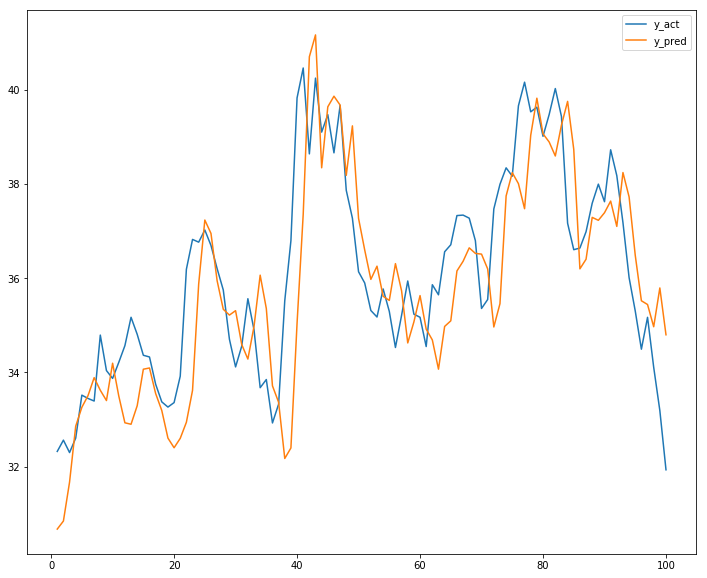

In [45]:
y_test_size = len(df_partial) - m2.train_size
y_act = np.array(df_partial.iloc[-1 * y_test_size:]['NDX']) - m2.y_train_mean
y_pred = yp_model_2[-1 * y_test_size:]
print(y_test_size,len(y_act),len(y_pred))
df_review = pd.DataFrame({'y_act':y_act,'y_pred':y_pred})

num_to_view = 100

beg_index = 1
end_index = bi+num_to_view
df_review.iloc[beg_index:end_index].plot(y=['y_act','y_pred'],figsize=(12,10))

### End